# Lorenzo Cassano
## 0 Importing Libraries

In [120]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
data_file = '/content/drive/MyDrive/ML/Data/horse-colic.csv'
delimiter = ',' #Check for the delimiter in the file, it could also be ;


#Or if we have problems with conversion, also this

col_names = range(1,29)

df = pd.read_csv(data_file, sep = delimiter,  names = col_names)
df = df.replace('?', np.nan)

In [123]:
df1 = df.drop([3, 25, 26, 27, 28], axis = 1)

## Data Exploration

In [124]:
df1.head()

,1,2,4,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,24
0,2,1,38.50,66,28,3,3,NaN,2,5,...,NaN,NaN,3,5,45.00,8.40,NaN,NaN,2,2
1,1,1,39.2,88,20,NaN,NaN,4,1,3,...,NaN,NaN,4,2,50,85,2,2,3,2
2,2,1,38.30,40,24,1,1,3,1,3,...,NaN,NaN,1,1,33.00,6.70,NaN,NaN,1,2
3,1,9,39.10,164,84,4,1,6,2,2,...,2,5.00,3,NaN,48.00,7.20,3,5.30,2,1
4,2,1,37.30,104,35,NaN,NaN,6,2,NaN,...,NaN,NaN,NaN,NaN,74.00,7.40,NaN,NaN,2,2


In [125]:
#Structure of numeric data
df1.describe()



,2,24
count,300.000000,300.000000
mean,1.640000,1.363333
std,2.173972,0.481763
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,2.000000
max,9.000000,2.000000


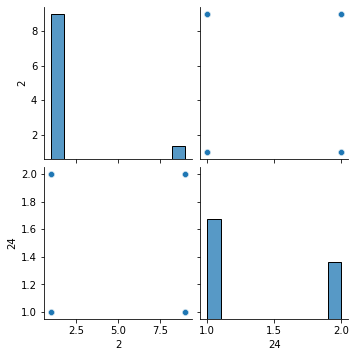

In [126]:
sns.pairplot(df1)

Showing the count of nulls for each remaining column.

In [127]:
df.isna().sum()

1       1
2       0
3       0
4      60
5      24
6      58
7      56
8      69
9      47
10     32
11     55
12     44
13     56
14    104
15    106
16    247
17    102
18    118
19     29
20     33
21    165
22    198
23      1
24      0
25      0
26      0
27      0
28      0
dtype: int64

## 2. Use column 23 as target for classification. Drop the rows where the
target is null.

In [128]:
target = 23
df2 = df1.dropna(axis=0, subset=[target])

In [129]:
column_names = df2.loc[:, df2.columns != target].columns

In [130]:
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
df3 = pd.DataFrame(imputer.fit_transform(df2.loc[:, df2.columns != target]), columns = column_names)

In [132]:
df3.head()

,1,2,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,21,22,24
0,2.0,1.0,38.5,66.0,28.0,3.000000,3.000000,2.853175,2.0,5.000000,...,1.753846,1.585492,4.707547,3.000000,5.000000,45.0,8.4,2.037313,3.039604,2.0
1,1.0,1.0,39.2,88.0,20.0,2.345679,2.021739,4.000000,1.0,3.000000,...,1.753846,1.585492,4.707547,4.000000,2.000000,50.0,85.0,2.000000,2.000000,2.0
2,2.0,1.0,38.3,40.0,24.0,1.000000,1.000000,3.000000,1.0,3.000000,...,1.753846,1.585492,4.707547,1.000000,1.000000,33.0,6.7,2.037313,3.039604,2.0
3,1.0,9.0,39.1,164.0,84.0,4.000000,1.000000,6.000000,2.0,2.000000,...,1.000000,2.000000,5.000000,3.000000,3.685083,48.0,7.2,3.000000,5.300000,1.0
4,2.0,1.0,37.3,104.0,35.0,2.345679,2.021739,6.000000,2.0,2.946721,...,1.753846,1.585492,4.707547,2.756345,3.685083,74.0,7.4,2.037313,3.039604,2.0


## Separating dataset

In [133]:
X = df3
y = df2[target]

In [135]:
ts = 0.3
random_state = 42
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size = ts, random_state = random_state)
print("Training on ", Xtrain.shape[0], " examples")

Training on  209  examples


## Preparing the enviroment

In [136]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = ytest, model.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

In [137]:
score = 'accuracy'
cv = 5 #number of split for cross validation
model_param = {'criterion':['gini', 'entropy'], 'max_depth':list(range(1,10)), 'min_samples_split': range(2,10)}
model_est = DecisionTreeClassifier(random_state=random_state)

model1 = GridSearchCV(model_est, model_param, scoring=score, cv=5) 
model1.fit(Xtrain,ytrain)
print_results(model1)

Best parameters set found on train set:

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}

Grid scores on train set:

0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 6}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 7}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 8}
0.598 (+/-0.032) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 9}
0.622 (+/-0.022) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
0.622 (+/-0.022) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3}
0.622 (+/-0.022) for {'criterion': 'gin

## Confusion matrix

Confusion matrix of the results:


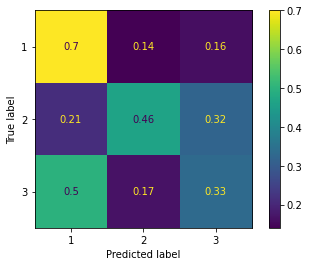

In [138]:
print("Confusion matrix of the results:")
plot_confusion_matrix(model1, Xtest, ytest,normalize= 'true')

In [139]:


y_pred = model1.predict(Xtest)
coh = cohen_kappa_score(ytest, y_pred)
f1 = f1_score(ytest, y_pred, average='macro')

print("F1 score = {:2}\nCohen Kappa Score = {:2}".format(round(f1,2), round(coh,2)))

F1 score = 0.49
Cohen Kappa Score = 0.3


## Repeting on other model

In [140]:
model_param = list(ParameterGrid({
    'n_estimators':[[20],[30],[40],[50]],
    'learning_rate':[[0.5],[0.75],[1],[1.25],[1.5]]}
))



model_est = AdaBoostClassifier(random_state=random_state)

model2 = GridSearchCV(model_est, model_param, scoring='accuracy', cv=5)

model2.fit(Xtrain, ytrain)

print_results(model2)

Best parameters set found on train set:

{'learning_rate': 1, 'n_estimators': 40}

Grid scores on train set:

0.622 (+/-0.184) for {'learning_rate': 0.5, 'n_estimators': 20}
0.607 (+/-0.150) for {'learning_rate': 0.5, 'n_estimators': 30}
0.617 (+/-0.093) for {'learning_rate': 0.5, 'n_estimators': 40}
0.608 (+/-0.115) for {'learning_rate': 0.5, 'n_estimators': 50}
0.574 (+/-0.179) for {'learning_rate': 0.75, 'n_estimators': 20}
0.593 (+/-0.212) for {'learning_rate': 0.75, 'n_estimators': 30}
0.579 (+/-0.184) for {'learning_rate': 0.75, 'n_estimators': 40}
0.603 (+/-0.213) for {'learning_rate': 0.75, 'n_estimators': 50}
0.584 (+/-0.104) for {'learning_rate': 1, 'n_estimators': 20}
0.622 (+/-0.192) for {'learning_rate': 1, 'n_estimators': 30}
0.636 (+/-0.204) for {'learning_rate': 1, 'n_estimators': 40}
0.603 (+/-0.195) for {'learning_rate': 1, 'n_estimators': 50}
0.535 (+/-0.149) for {'learning_rate': 1.25, 'n_estimators': 20}
0.536 (+/-0.191) for {'learning_rate': 1.25, 'n_estimators': 

Confusion matrix of the results:


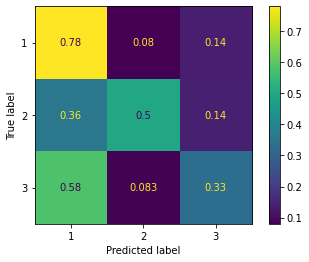

In [141]:
print("Confusion matrix of the results:")
plot_confusion_matrix(model2, Xtest, ytest,normalize= 'true')

In [143]:
y_pred = model2.predict(Xtest)
coh = cohen_kappa_score(ytest, y_pred)
f1 = f1_score(ytest, y_pred, average='macro')

print("F1 score = {}\nCohen Kappa Score = {}".format(round(f1,2), round(coh,2)))

F1 score = 0.54
Cohen Kappa Score = 0.35


In this case the best model is ADABoost, because it is an ensemble learning model 